In [7]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 5.2/150.0 MB 31.9 MB/s eta 0:00:05
   -- ------------------------------------- 9.4/150.0 MB 25.6 MB/s eta 0:00:06
   --- ------------------------------------ 13.6/150.0 MB 23.1 MB/s eta 0:00:06
   ---- ----------------------------------- 17.6/150.0 MB 22.2 MB/s eta 0:00:06
   ----- ---------------------------------- 21.5/150.0 MB 21.6 MB/s eta 0:00:06
   ------ --------------------------------- 26.0/150.0 MB 21.4 MB/s eta 0:00:06
   ------- -------------------------------- 29.9/150.0 MB 21.1 MB/s eta 0:00:06
   --------- ------------------------------ 33.8/150.0 MB 20.6 MB/s eta 0:00:06
   ---------- ----------------------------- 37.7/150.0 MB 20.7 MB/s eta 0:00:06
   ----------- ---------------------------- 41.7/150.0 MB 20.4 MB/s eta 0:00:06
   ------------ --------------------------- 45.9/150.0 MB 20.4 MB/s eta 0:00:06
   ------------- -------------------------- 49.8/15


✅ SMOTE Applied: Class Distribution After Oversampling:
is_fraud
0    128974
1     25794
Name: count, dtype: int64


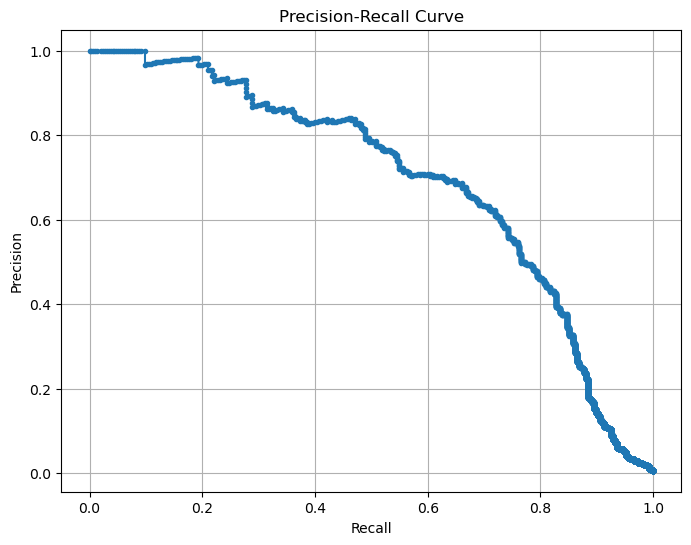


🔥 Optimal Threshold: 0.9880

🔹 Random Forest with Class Weights Performance:
Accuracy: 0.9965450226732887
Precision: 0.7976878612716763
Recall: 0.46779661016949153
F1 Score: 0.5897435897435898
Confusion Matrix:
 [[55242    35]
 [  157   138]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     55277
           1       0.80      0.47      0.59       295

    accuracy                           1.00     55572
   macro avg       0.90      0.73      0.79     55572
weighted avg       1.00      1.00      1.00     55572


🔹 XGBoost with Class Imbalance Handling Performance:
Accuracy: 0.989167206506874
Precision: 0.3111931119311193
Recall: 0.8576271186440678
F1 Score: 0.4566787003610108
Confusion Matrix:
 [[54717   560]
 [   42   253]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     55277
           1       0.31      0.86      0.46       29

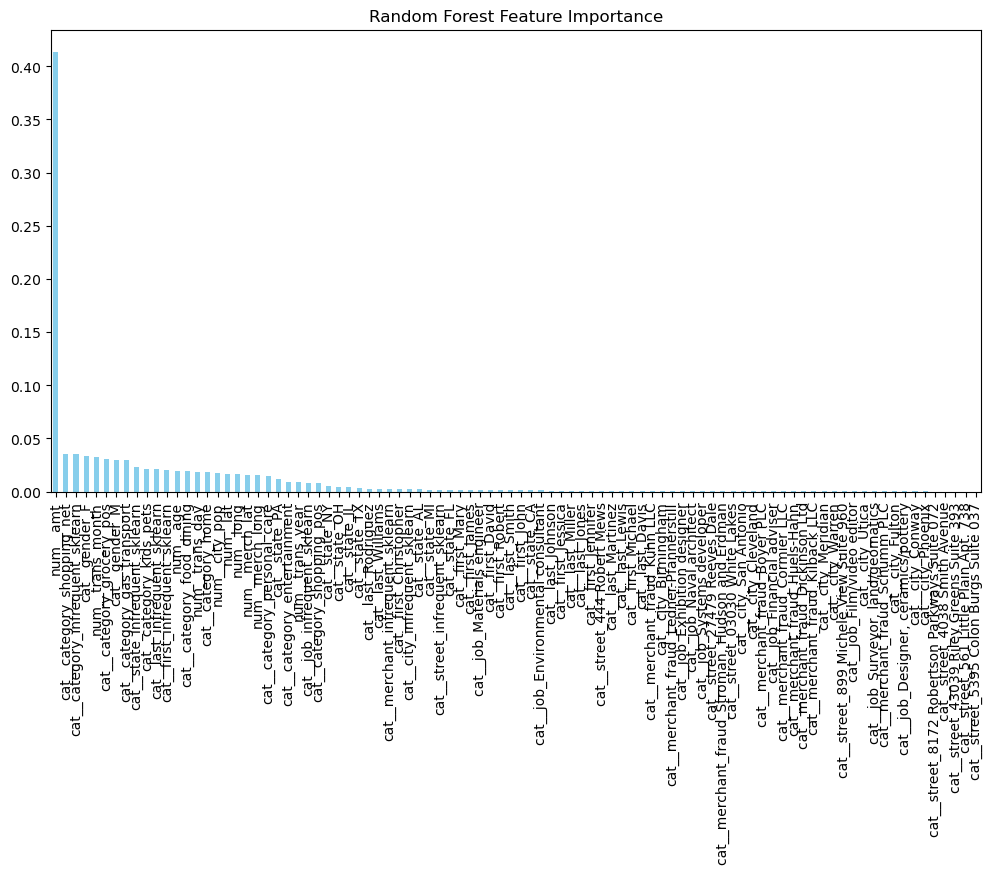

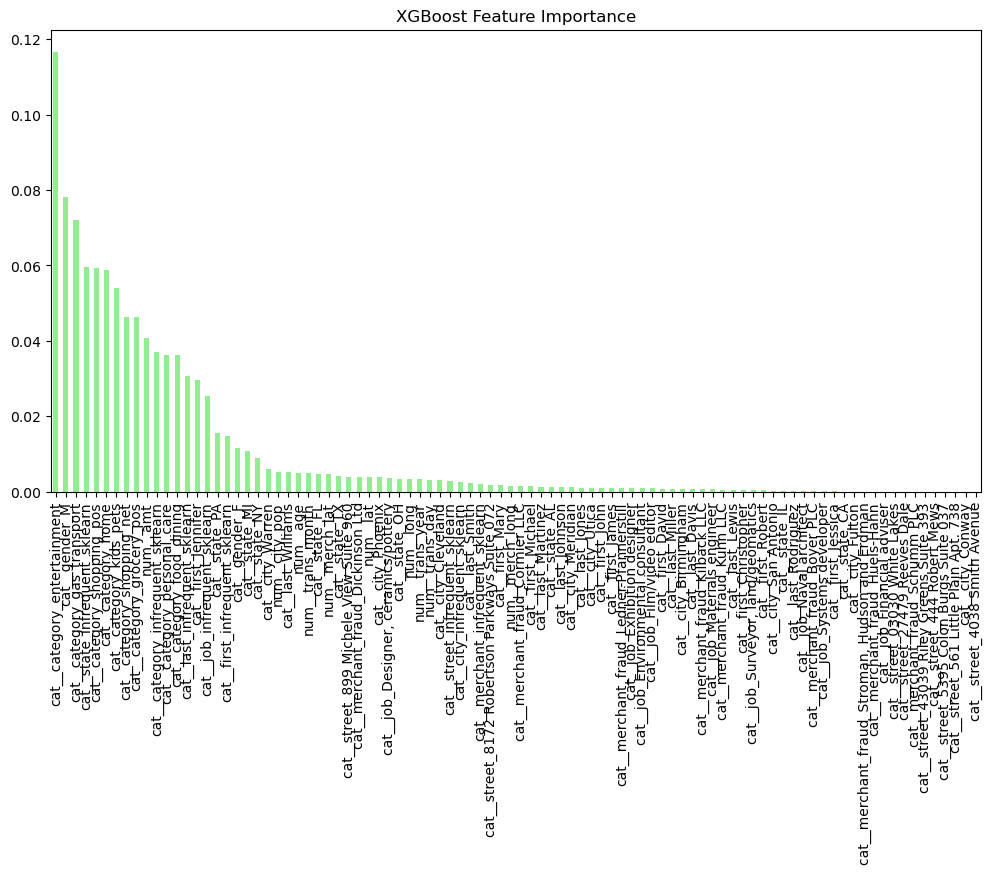


🔥 Best Parameters: {'scale_pos_weight': 5, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1}


In [11]:
# --- 🌟 IMPORT LIBRARIES 🌟 ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 🌟 LOAD DATA 🌟 ---
train_file = r"C:\Users\nive1\OneDrive\Desktop\NIVETHA\codsoft\fraudTrain.csv"
test_file = r"C:\Users\nive1\OneDrive\Desktop\NIVETHA\codsoft\fraudTest.csv"

# ✅ Load the datasets
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# ✅ Sample a smaller portion of the dataset for faster execution
train_data = train_data.sample(frac=0.1, random_state=42)
test_data = test_data.sample(frac=0.1, random_state=42)

# ✅ Combine the sampled datasets
data = pd.concat([train_data, test_data], ignore_index=True)

# --- 🌟 DATA CLEANING 🌟 ---
data.drop(['Unnamed: 0', 'trans_num', 'unix_time'], axis=1, inplace=True)

# Convert dates
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['dob'] = pd.to_datetime(data['dob'])

# Create new features: Age and transaction breakdown
data['age'] = (pd.to_datetime('today') - data['dob']).dt.days // 365
data['trans_year'] = data['trans_date_trans_time'].dt.year
data['trans_month'] = data['trans_date_trans_time'].dt.month
data['trans_day'] = data['trans_date_trans_time'].dt.day

# Drop original date columns
data.drop(['trans_date_trans_time', 'dob'], axis=1, inplace=True)

# Separate features and target
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

# --- 🌟 PREPROCESSING 🌟 ---
categorical_cols = ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'trans_year', 'trans_month', 'trans_day']),
        ('cat', OneHotEncoder(handle_unknown='ignore', max_categories=10), categorical_cols)  # Limit one-hot encoding categories
    ])

# ✅ Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply preprocessing pipeline
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# --- 🌟 APPLY SMOTE (LIMITED OVERSAMPLING) 🌟 ---
# Use SMOTE only on a smaller sample for efficiency
smote = SMOTE(sampling_strategy=0.2, random_state=42)  
X_train_bal, y_train_bal = smote.fit_resample(X_train_preprocessed, y_train)

print("\n✅ SMOTE Applied: Class Distribution After Oversampling:")
print(pd.Series(y_train_bal).value_counts())

# --- 🌟 RANDOM FOREST 🌟 ---
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_preprocessed)

# --- 🌟 XGBOOST 🌟 ---
xgb = XGBClassifier(scale_pos_weight=(len(y_train) / sum(y_train)), random_state=42, n_jobs=-1)
xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test_preprocessed)

# --- 🌟 THRESHOLD OPTIMIZATION 🌟 ---
y_probs = xgb.predict_proba(X_test_preprocessed)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

f1_scores = (2 * precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\n🔥 Optimal Threshold: {optimal_threshold:.4f}")

# Apply the optimal threshold
y_pred_optimized = (y_probs >= optimal_threshold).astype(int)

# --- 🌟 MODEL EVALUATION FUNCTION 🌟 ---
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n🔹 {model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

# --- 🌟 EVALUATE MODELS 🌟 ---
evaluate_model(y_test, y_pred_rf, "Random Forest with Class Weights")
evaluate_model(y_test, y_pred_xgb, "XGBoost with Class Imbalance Handling")
evaluate_model(y_test, y_pred_optimized, "XGBoost with Threshold Optimization")

# --- 🌟 FEATURE IMPORTANCE VISUALIZATION 🌟 ---
rf_feature_importance = pd.Series(rf.feature_importances_, index=preprocessor.get_feature_names_out()).sort_values(ascending=False)
xgb_feature_importance = pd.Series(xgb.feature_importances_, index=preprocessor.get_feature_names_out()).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
rf_feature_importance.plot(kind='bar', color='skyblue', title='Random Forest Feature Importance')
plt.show()

plt.figure(figsize=(12, 6))
xgb_feature_importance.plot(kind='bar', color='lightgreen', title='XGBoost Feature Importance')
plt.show()

# --- 🌟 RANDOMIZED SEARCH FOR FASTER TUNING 🌟 ---
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'scale_pos_weight': [3, 5, 10]
}

rs = RandomizedSearchCV(XGBClassifier(random_state=42), param_dist, cv=3, n_iter=5, scoring='f1', n_jobs=-1)
rs.fit(X_train_bal, y_train_bal)

print("\n🔥 Best Parameters:", rs.best_params_)
